In [14]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import ToPILImage
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import random
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.core.debugger import set_trace
import pandas as pd
import datetime
import pytz
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import re
import torch.nn.functional as F

## 파라미터 설정

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
'''
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")
'''

'\n# 맥 mps 설정\ndevice = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")\nprint(f"현재 디바이스는 {device} 입니다.")\n'

In [17]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':20,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE': 64,
    'SEED':41,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'train_magnification':"10X"
}

In [18]:
kst = pytz.timezone('Asia/Seoul')
current_datetime = datetime.datetime.now(kst)
day = current_datetime.strftime("%Y_%m_%d")
hour = current_datetime.strftime("%I:%M_%p")
print(day, hour)

2023_06_20 12:55_PM


In [19]:
# server path
output_path = f"/data/output/{day}"
pth_path = f"/data/pthfile/{day}"
trainframe_path = f"{output_path}/trainframe"
train_data_path = f"/data/PDA_mask_img/train/{CFG['train_magnification']}/**/*.png"
val_data_path = f"/data/PDA_mask_img/validation/{CFG['train_magnification']}/**/*.png"

In [20]:
# server output name
trainframe_name = f"{trainframe_path}/train:{CFG['train_magnification']}_epoch:{CFG['EPOCHS']}_{hour}.xlsx"
pth_name=f"{pth_path}/train:{CFG['train_magnification']}_epoch:{CFG['EPOCHS']}_{hour}.pth"

In [21]:
# local path
'''
output_path = f"git_ignore/output/{day}"
pth_path = f"git_ignore/pthfile/{day}"
trainframe_path = f"{output_path}/trainframe"
train_data_path = f"git_ignore/PDA_mask_img/train/{CFG['train_magnification']}/**/*.png"
val_data_path = f"git_ignore/PDA_mask_img/validation_mask/{CFG['train_magnification']}/**/*.png"
'''

'\noutput_path = f"git_ignore/output/{day}"\npth_path = f"git_ignore/pthfile/{day}"\ntrainframe_path = f"{output_path}/trainframe"\ntrain_data_path = f"git_ignore/PDA_mask_img/train/{CFG[\'train_magnification\']}/**/*.png"\nval_data_path = f"git_ignore/PDA_mask_img/validation_mask/{CFG[\'train_magnification\']}/**/*.png"\n'

In [22]:
# local output name
'''
trainframe_name = f"{trainframe_path}/train:{CFG['train_magnification']}_epoch:{CFG['EPOCHS']}_{hour}.xlsx"
pth_name=f"{pth_path}/train:{CFG['train_magnification']}_epoch:{CFG['EPOCHS']}_{hour}.pth"
'''

'\ntrainframe_name = f"{trainframe_path}/train:{CFG[\'train_magnification\']}_epoch:{CFG[\'EPOCHS\']}_{hour}.xlsx"\npth_name=f"{pth_path}/train:{CFG[\'train_magnification\']}_epoch:{CFG[\'EPOCHS\']}_{hour}.pth"\n'

In [23]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [24]:
train_path_list = sorted(glob.glob(train_data_path))
train_mask_path = train_path_list[0::2]
train_img_path = train_path_list[1::2]
train_mask_path[:5]

['/data/PDA_mask_img/train/10X/C3L-00017-22/C3L-00017-22 [d=2.02347,x=10073,y=10073,w=1036,h=1036]-labelled.png',
 '/data/PDA_mask_img/train/10X/C3L-00017-22/C3L-00017-22 [d=2.02347,x=10073,y=10603,w=1036,h=1036]-labelled.png',
 '/data/PDA_mask_img/train/10X/C3L-00017-22/C3L-00017-22 [d=2.02347,x=10073,y=11133,w=1036,h=1036]-labelled.png',
 '/data/PDA_mask_img/train/10X/C3L-00017-22/C3L-00017-22 [d=2.02347,x=10073,y=11663,w=1036,h=1036]-labelled.png',
 '/data/PDA_mask_img/train/10X/C3L-00017-22/C3L-00017-22 [d=2.02347,x=10073,y=12193,w=1036,h=1036]-labelled.png']

In [25]:
val_path_list = sorted(glob.glob(val_data_path))
val_mask_path = val_path_list[0::2]
val_img_path = val_path_list[1::2]
val_mask_path[:5]

['/data/PDA_mask_img/validation/10X/C3L-00277-22/C3L-00277-22 [d=2.02347,x=0,y=0,w=1036,h=1036]-labelled.png',
 '/data/PDA_mask_img/validation/10X/C3L-00277-22/C3L-00277-22 [d=2.02347,x=0,y=1036,w=1036,h=1036]-labelled.png',
 '/data/PDA_mask_img/validation/10X/C3L-00277-22/C3L-00277-22 [d=2.02347,x=0,y=10360,w=1036,h=1036]-labelled.png',
 '/data/PDA_mask_img/validation/10X/C3L-00277-22/C3L-00277-22 [d=2.02347,x=0,y=11396,w=1036,h=1036]-labelled.png',
 '/data/PDA_mask_img/validation/10X/C3L-00277-22/C3L-00277-22 [d=2.02347,x=0,y=12432,w=1036,h=1036]-labelled.png']

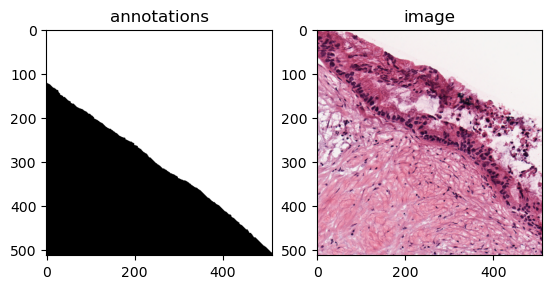

In [26]:
annotation = cv2.imread(train_mask_path[0])
image = cv2.imread(train_img_path[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)

In [27]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, transform = None):
        self.image = img_path
        self.mask = mask_path
        
        n_samples =  len(self.image)
        
        # 데이터 미리 섞어줌
        np.random.seed(CFG['SEED'])
        idxs = np.random.permutation(range(n_samples))
        
        self.image = np.array(self.image)[idxs]
        self.mask = np.array(self.mask)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.image) # 데이터셋 길이
    
    def __getitem__(self, i):
        image = np.array(Image.open(self.image[i]))
        mask = np.array(Image.open(self.mask[i]))
        data = self.transform(image = image, mask = mask)
        image = data["image"]
        mask = data["mask"]
        return image, mask

## 데이터 불러오기

In [28]:
# transform
train_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        A.OneOf([
                A.HorizontalFlip(p=0.3),
                A.RandomRotate90(p=0.3),
                A.VerticalFlip(p=0.3)            
        ], p=0.3),
        ToTensorV2(transpose_mask=True)
])

'''
A.OneOf([
        A.MotionBlur(p=0.3),
        A.OpticalDistortion(p=0.3),
        A.GaussNoise(p=0.3)                 
], p=0.3),
'''

'\nA.OneOf([\n        A.MotionBlur(p=0.3),\n        A.OpticalDistortion(p=0.3),\n        A.GaussNoise(p=0.3)                 \n], p=0.3),\n'

In [29]:
val_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        ToTensorV2(transpose_mask=True)
])

In [30]:
# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                          mask_path = train_mask_path,
                          transform = train_transform)

val_set = CustomDataset(img_path = val_img_path,
                         mask_path= val_mask_path,
                         transform = val_transform)

In [31]:
train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
val_loader = DataLoader(val_set, batch_size = CFG["BATCH_SIZE"])

In [32]:
print(f"train_data : {len(train_set)} / val_data : {len(val_set)}")

train_data : 5181 / val_data : 870


## 학습

In [33]:
# Modeling
class ResUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResUNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)
        x1 = self.encoder.maxpool(x1)

        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = self.relu(self.conv1(x))

        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = self.relu(self.conv2(x))

        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = self.relu(self.conv3(x))

        x = self.conv4(x)

        # Resize to 512x512
        x = nn.functional.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)

        return x

In [34]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice 

In [35]:
# 학습 파라미터
model = ResUNet(num_classes=1).to(device)
model = nn.DataParallel(model)
optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
criterion = DiceLoss().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
def dice_score(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [37]:
# 평균값 계산
class AverageMeter: 
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [38]:
class EarlyStop:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [39]:
loss_meter = AverageMeter()
score_meter = AverageMeter()
early_stopping = EarlyStop(patience = 20, delta = 0)

In [40]:
def validation(model, criterion, val_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(val_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())

        val_loss_mean = loss_meter.avg
        val_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    return val_loss_mean, val_score_mean

In [41]:
def train(model, criterion, optimizer, train_loader, val_loader, scheduler, device):
    best_score = 0
    best_model = None
    result_arr = np.empty((0,4), float)
    columns = []
    model.train()
    for epoch in range(CFG["EPOCHS"]):
        try:
            for img, label in tqdm(train_loader):
                optimizer.zero_grad()
                out = model(img.to(device))
                out = torch.squeeze(out)
                pred = torch.ge(out.sigmoid(), 0.5).float()
                label = torch.squeeze(label).to(device)
                score = dice_score(pred, label)
                loss = criterion(out, label.type(torch.FloatTensor).to(device))

                loss_meter.update(loss.item())
                score_meter.update(score.item())

                loss.backward()
                optimizer.step()
                
            train_loss_mean = loss_meter.avg
            train_score_mean = score_meter.avg
            loss_meter.reset()
            score_meter.reset()
            val_loss, val_score = validation(model, criterion, val_loader, device)

            print(f"epoch{epoch+1}: Train_loss:{train_loss_mean} Train_score:{train_score_mean} Val_loss:{val_loss} Val_score:{val_score}")
            result_arr = np.append(result_arr, np.array([[train_loss_mean,train_score_mean, val_loss, val_score]]), axis = 0)
            if scheduler is not None:
                scheduler.step(val_score)
                  
            if best_score < val_score:
                best_score = val_score
                best_model = model
                
            early_stopping(val_score)
            if early_stopping.early_stop:
                columns.append(f"epoch:{epoch+1}")
                print("Early stopping!")
                break
        except KeyboardInterrupt:
            best_model = model
        columns.append(f"epoch:{epoch+1}")
    return best_model, result_arr, columns

## Run

In [42]:
infer_model, result, columns = train(model, criterion, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch1: Train_loss:0.5782200318795664 Train_score:0.46221032499531167 Val_loss:0.3707182151930673 Val_score:0.6304209296192441


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch2: Train_loss:0.30454864619690697 Train_score:0.6959402667887417 Val_loss:0.31743728263037546 Val_score:0.6829109489917755


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch3: Train_loss:0.2569064012280217 Train_score:0.7433101233140922 Val_loss:0.35404309204646517 Val_score:0.6461640638964516


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch4: Train_loss:0.23417738043231728 Train_score:0.765995466414793 Val_loss:0.3161179210458483 Val_score:0.6840975540024894


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch5: Train_loss:0.22036162791428743 Train_score:0.7797837640032356 Val_loss:0.30606975725718905 Val_score:0.694199481180736


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch6: Train_loss:0.21912783605081063 Train_score:0.7810348353268187 Val_loss:0.3271245573248182 Val_score:0.6730162841933114


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch7: Train_loss:0.18926893045872817 Train_score:0.8108893470999635 Val_loss:0.2625212711947305 Val_score:0.7377545833587646


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch8: Train_loss:0.1908080599926136 Train_score:0.8093864645486997 Val_loss:0.2838049360683986 Val_score:0.7164738391126905


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch9: Train_loss:0.16538640157676038 Train_score:0.8348506556616889 Val_loss:0.2856300984110151 Val_score:0.7146092525550297


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch10: Train_loss:0.15605034798751644 Train_score:0.8442325010711764 Val_loss:0.2722308806010655 Val_score:0.7281593893255506
Epoch 00010: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch11: Train_loss:0.13019289573033652 Train_score:0.8701653156751468 Val_loss:0.25935056805610657 Val_score:0.7411053308418819


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch12: Train_loss:0.123814226668558 Train_score:0.8765679987860314 Val_loss:0.2420320553439004 Val_score:0.7587604863303048


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch13: Train_loss:0.11590347540231398 Train_score:0.8845138689618052 Val_loss:0.2629301973751613 Val_score:0.7376128903457096


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch14: Train_loss:0.11870778416409905 Train_score:0.8817150011474704 Val_loss:0.2583247039999281 Val_score:0.7421744423253196


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch15: Train_loss:0.10996093205463739 Train_score:0.89043653084908 Val_loss:0.2561489811965397 Val_score:0.7443258549485888
Epoch 00015: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch16: Train_loss:0.10020881670492666 Train_score:0.9002102929868816 Val_loss:0.25457647017070223 Val_score:0.7459401062556675


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch17: Train_loss:0.09868125635900615 Train_score:0.9017397768703508 Val_loss:0.24798088840075902 Val_score:0.7525240182876587


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch18: Train_loss:0.09541540749279069 Train_score:0.9049800634384155 Val_loss:0.24341108969279698 Val_score:0.7574092149734497
Epoch 00018: reducing learning rate of group 0 to 1.2500e-05.


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch19: Train_loss:0.0924274111971443 Train_score:0.9079679213924172 Val_loss:0.2457070435796465 Val_score:0.7548269714627948


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

epoch20: Train_loss:0.08962020756285867 Train_score:0.9107646853835495 Val_loss:0.2605828515120915 Val_score:0.7398623824119568


## 결과 그래프

In [46]:
result_df = pd.DataFrame(data = result, index = columns, columns = ["Train Loss", "Train Dice Score", "Validation Loss", "Validation Dice Score"])
result_df.tail()

,Train Loss,Train Dice Score,Validation Loss,Validation Dice Score
epoch:16,0.100209,0.900210,0.254576,0.745940
epoch:17,0.098681,0.901740,0.247981,0.752524
epoch:18,0.095415,0.904980,0.243411,0.757409
epoch:19,0.092427,0.907968,0.245707,0.754827
epoch:20,0.089620,0.910765,0.260583,0.739862


<Axes: >

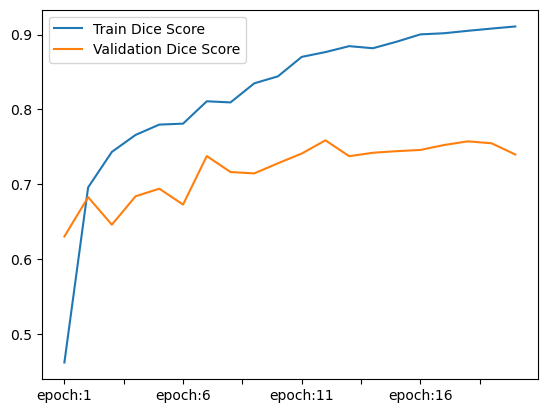

In [47]:
result_df[["Train Dice Score", "Validation Dice Score"]].plot()

<Axes: >

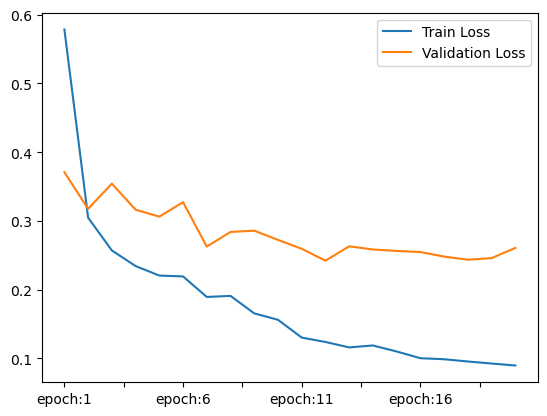

In [48]:
result_df[["Train Loss", "Validation Loss"]].plot()

## 결과 저장

In [49]:
# 데이터프레임 저장
os.makedirs(f"{output_path}", exist_ok=True)
os.makedirs(f"{trainframe_path}", exist_ok=True)
result_df.to_excel(f"{trainframe_name}")

In [50]:
# 모델 저장
os.makedirs(f"{pth_path}", exist_ok=True)
torch.save(infer_model.state_dict(), pth_name)